In [11]:
import pandas as pd 
import numpy as np

import sklearn
import matplotlib.pyplot as plt

from scipy.stats import norm
import statistics
import seaborn as sns
from scipy.stats import f_oneway
import scikit_posthocs as sp
from scipy.stats import kruskal
import statsmodels.stats.multicomp as mc

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score



# Classification
- This notebook will classify the different claims with the help of the significant features.
- We import the computed Liar data frame and conduct several classification algorithms

In [12]:
df_classification = pd.read_csv('/Users/sandrobarreshamers/Thesis_IS_fake_news/ThesisData/Liar_computed_final_version.csv')


In [13]:
df_classification.head()

,Unnamed: 0,json_id,claim,object,binary label,readability,compressed_size,vader_neg,vader_neu,vader_pos,...,pos_NOUN,pos_NUM,pos_PART,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SYM,pos_VERB,pos_X
0,0,10540.json,half-true,When did the decline of coal start? It started...,2,71.815000,11444,0.000,0.902,0.098,...,5.0,0.0,1.0,1.0,4.0,4.0,0.0,0.0,4.0,0.0
1,1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",2,71.781579,9089,0.107,0.687,0.206,...,2.0,0.0,1.0,0.0,7.0,3.0,0.0,0.0,3.0,0.0
2,2,1123.json,false,Health care reform legislation is likely to ma...,1,53.655000,5511,0.000,0.606,0.394,...,7.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3,9028.json,half-true,The economic turnaround started at the end of ...,2,61.325000,4710,0.000,1.000,0.000,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,12465.json,true,The Chicago Bears have had more starting quart...,0,54.096667,12203,0.119,0.828,0.053,...,5.0,2.0,0.0,0.0,4.0,3.0,1.0,0.0,3.0,0.0


### Binary classification
We exclude the 'In Between' labels from the data frame since we will conduct a binary classification.

In [14]:
filtered_df = df_classification[df_classification['binary label'] != 2]

filtered_df.head()
filtered_df.columns

Index(['Unnamed: 0', 'json_id', 'claim', 'object', 'binary label',
       'readability', 'compressed_size', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'tot_ner_count', 'ner_counts', 'input_vector_ner',
       'NER_CARDINAL', 'NER_DATE', 'NER_EVENT', 'NER_FAC', 'NER_GPE',
       'NER_LANGUAGE', 'NER_LAW', 'NER_LOC', 'NER_MONEY', 'NER_NORP',
       'NER_ORDINAL', 'NER_ORG', 'NER_PERCENT', 'NER_PERSON', 'NER_PRODUCT',
       'NER_QUANTITY', 'NER_TIME', 'NER_WORK_OF_ART', 'pos counts',
       'input_vector_pos', 'pos_ADJ', 'pos_ADP', 'pos_ADV', 'pos_AUX',
       'pos_CCONJ', 'pos_DET', 'pos_INTJ', 'pos_NOUN', 'pos_NUM', 'pos_PART',
       'pos_PRON', 'pos_PROPN', 'pos_PUNCT', 'pos_SCONJ', 'pos_SYM',
       'pos_VERB', 'pos_X'],
      dtype='object')

In [15]:
def count_claims(df, claim):
    count_claim = len(df[df['claim']== claim])
    return count_claim

false_claims = count_claims(filtered_df,'false')
true_claims =  count_claims(filtered_df,'true')
print(f'false claims {false_claims}')
print(f'true claims {true_claims}')

false claims 1994
true claims 1676


## Classification pre-face
- in this code blocks, we prepare the data and set up the experiment to later classify the False and True label
- Based on the previously conducted KST and Dunn tests, we now train the different models on the significant features
- We divide the data in train and test data
- we instantiate the K-fold cross validation for both the train and test data with k=5

In [22]:
significant_features = ['readability', 'compressed_size', 'tot_ner_count','NER_PERSON','NER_DATE','NER_CARDINAL','pos_NOUN', 'pos_ADJ',
       'pos_VERB', 'pos_ADV', 'pos_ADP',
       'pos_DET', 'pos_NUM', 'pos_PART', 'pos_PROPN',
       'pos_PUNCT', 'pos_SCONJ']

### Train and Test data
- In this code, we divide the code into test and train data. 
- Furthermore, this code snippet performs random oversampling on the training data to address the class imbalance.
- It resamples the training data to increase the number of instances in the minority class by randomly replicating samples. 
- The resampled data is stored in X_train_resampled and y_train_resampled, which can be used for training a machine-learning model

In [23]:
from imblearn.over_sampling import RandomOverSampler
X = filtered_df[significant_features]

y = filtered_df['binary label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


In [24]:
class_counts_init = filtered_df['binary label'].value_counts()
print(f'Initial number of train instances: \nLabel : 0(True), counts:{class_counts_init[0]}\nLabel: 1(False), counts:{class_counts_init[1]}\n')

class_counts_over = pd.Series(y_train_resampled).value_counts()
print(f'Number of train instances after oversampling: \nLabel : 0(True), counts:{class_counts_over[0]}\nLabel: 1(False), counts:{class_counts_over[1]}\n')


Initial number of train instances: 
Label : 0(True), counts:1676
Label: 1(False), counts:2833

Number of train instances after oversampling: 
Label : 0(True), counts:2260
Label: 1(False), counts:2260



In [25]:
import sklearn.metrics as metrics
kfold_train = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_test = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')

## Classification Algorithms
- In the following code blocks, we perform the three ML classification algorithms discussed in the research paper; the three models are:
  - Naive Bias
  - Random Forest
  - Gradient Booster 
  - Dummy classifier

### Naive Bias 

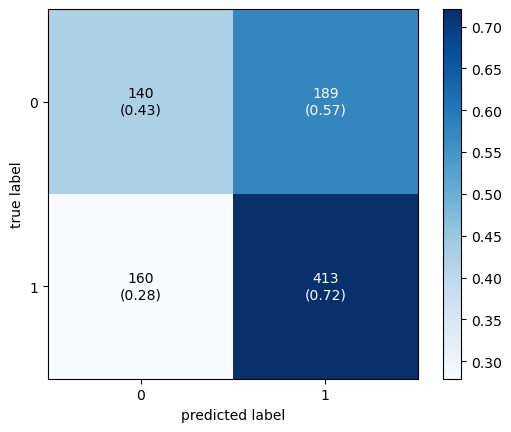

In [28]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm_NB =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_NB,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

In [29]:
# Train
scores_NB_train = cross_val_score(nb_model, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold crss training data: %0.2f, cv:(+/- %0.2f)" % (scores_NB_train.mean(), 
                                                            (scores_NB_train.std()/scores_NB_train.mean())))

# Test
scores_NB_test = cross_val_score(nb_model, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data: %0.2f, cv:(+/- %0.2f)" % (scores_NB_test.mean(), 
                                                            (scores_NB_test.std()/scores_NB_test.mean())))

f1 score k fold crss training data: 0.56, cv:(+/- 0.03)
f1 score k fold cross for the test data: 0.57, cv:(+/- 0.05)


### Random forrest

[[120 209]
 [139 434]]


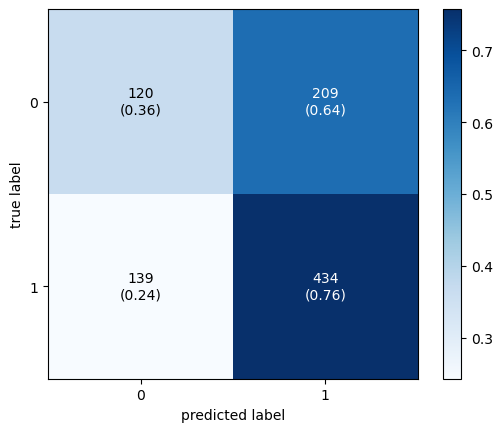

In [30]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)


cm_RF =confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_RF,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

# improved from 51% to 55%
print(cm_RF)

In [31]:
# Train
scores_RF_train = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross training data: %0.2f (+/- %0.2f)" % (scores_RF_train.mean(), 
                                                            (scores_RF_train.std()/scores_RF_train.mean())))

#Test
scores_RF_test = cross_val_score(clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores_RF_test.mean(), 
                                                            (scores_RF_test.std()/scores_RF_test.mean())))

f1 score k fold cross training data: 0.75 (+/- 0.01)
f1 score k fold cross for the test data: 0.54 (+/- 0.05)


### Gradient Booster

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

           0       0.48      0.57      0.52       329
           1       0.72      0.64      0.68       573

    accuracy                           0.61       902
   macro avg       0.60      0.60      0.60       902
weighted avg       0.63      0.61      0.62       902



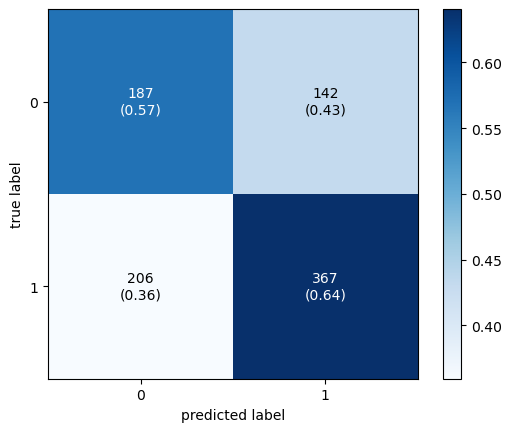

In [33]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08, max_depth=2, subsample=0.5, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)
y_pred = gb_clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm_GB = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm_GB,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)



In [34]:
#Train
scores_GB_train = cross_val_score(gb_clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold corss train:%0.2f cf:(+/- %0.2f)" % (scores_GB_train.mean(), 
                                                            (scores_GB_train.std()/scores_GB_train.mean())))

#Test
scores_GB_test = cross_val_score(gb_clf, X_test, y_test, cv=kfold_test, scoring=scorer)
print("f1 score k fold cross for the test data: %0.2f cf:(+/- %0.2f)" % (scores_GB_test.mean(), 
                                                            (scores_GB_test.std()/scores_GB_test.mean())))

f1 score k fold corss train:0.61 cf:(+/- 0.02)
f1 score k fold cross for the test data: 0.56 cf:(+/- 0.06)


### Baseline

In [35]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_resampled, y_train_resampled)
y_pred_majority = dummy_clf.predict(X_test)
accuracy_majority = accuracy_score(y_test, y_pred_majority)

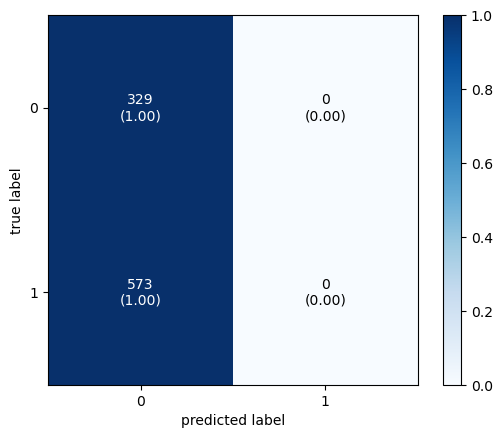

In [36]:
cm_dummy =confusion_matrix(y_test, y_pred_majority)
fig, ax = plot_confusion_matrix(conf_mat=cm_dummy,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)



In [37]:
# Train
scores_Dummy_train = cross_val_score(dummy_clf, X_train_resampled, y_train_resampled, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross training data:%0.2f (+/- %0.2f)" % (scores_Dummy_train.mean(), scores_Dummy_train.std()))

#Test
scores_Dummy_test = cross_val_score(dummy_clf, X_test, y_test, cv=kfold_train, scoring='f1_macro')
print("f1 score k fold cross for the test data: %0.2f (+/- %0.2f)" % (scores_Dummy_test.mean(), scores_Dummy_test.std()))

f1 score k fold cross training data:0.33 (+/- 0.00)
f1 score k fold cross for the test data: 0.39 (+/- 0.02)


# Evaluation
- In this code block, the different classification ML models are evaluated and compared against each other
- Subsequently, the evaluation is displayed in a table and later printed in latex format
- this latex format is used in the research paper

In [38]:
import pandas as pd
import numpy as np


metrics = ['F1 Score Test', 'F1 Score Train', 'TP', 'FP', 'FN', 'TN', 'Relative Improvement']
model_names = ['Naive Bayes', 'Random Forest', 'Gradient Boosting']

Relative_Improvement_NB = (np.mean(scores_NB_test)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_RF = (np.mean(scores_RF_test)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100
Relative_Improvement_GB = (np.mean(scores_GB_test)-np.mean(scores_Dummy_test))/np.mean(scores_Dummy_test) * 100


scores_NB = [np.mean(scores_NB_test) * 100, np.mean(scores_NB_train) * 100, cm_NB[0,0], cm_NB[0,1], cm_NB[1,0], cm_NB[1,1], Relative_Improvement_NB]
scores_RF = [np.mean(scores_RF_test) * 100, np.mean(scores_RF_train) * 100, cm_RF[0,0], cm_RF[0,1], cm_RF[1,0], cm_RF[1,1], Relative_Improvement_RF]
scores_GB = [np.mean(scores_GB_test) * 100, np.mean(scores_GB_train) * 100, cm_GB[0,0], cm_GB[0,1], cm_GB[1,0], cm_GB[1,1], Relative_Improvement_GB]


eval_df = pd.DataFrame({
    'Model': model_names,
    'F1 Score Test (%)': [f"{np.mean(scores_NB_test) * 100:.2f} (+/- {(scores_NB_test.std()/scores_NB_test.mean()) * 100:.2f})",
                          f"{np.mean(scores_RF_test) * 100:.2f} (+/- {(scores_RF_test.std()/scores_RF_test.mean()) * 100:.2f})",
                          f"{np.mean(scores_GB_test) * 100:.2f} (+/- {(scores_GB_test.std()/scores_GB_test.mean()) * 100:.2f})"],
    'F1 Score Train (%)': [f"{np.mean(scores_NB_train) * 100:.2f} (+/- {(scores_NB_train.std()/scores_NB_train.mean()) * 100:.2f})",
                           f"{np.mean(scores_RF_train) * 100:.2f} (+/- {(scores_RF_train.std()/scores_RF_train.mean()) * 100:.2f})",
                           f"{np.mean(scores_GB_train) * 100:.2f} (+/- {(scores_GB_train.std()/scores_GB_train.mean()) * 100:.2f})"],
    'TP': [scores_NB[2], scores_RF[2], scores_GB[2]],
    'FP': [scores_NB[3], scores_RF[3], scores_GB[3]],
    'FN': [scores_NB[4], scores_RF[4], scores_GB[4]],
    'TN': [scores_NB[5], scores_RF[5], scores_GB[5]],
    'Relative Improvement (%)': [round(scores_NB[6], 2), round(scores_RF[6], 2), round(scores_GB[6], 2)]
})



eval_df.set_index('Model', inplace=True)

print(eval_df)


                  F1 Score Test (%) F1 Score Train (%)   TP   FP   FN   TN  \
Model                                                                        
Naive Bayes        57.10 (+/- 5.47)   55.83 (+/- 3.19)  140  189  160  413   
Random Forest      54.41 (+/- 4.78)   75.26 (+/- 1.19)  120  209  139  434   
Gradient Boosting  56.20 (+/- 5.68)   60.82 (+/- 2.45)  187  142  206  367   

                   Relative Improvement (%)  
Model                                        
Naive Bayes                           47.19  
Random Forest                         40.25  
Gradient Boosting                     44.86  


In [1]:
#latex_table_ML_eval = eval_df.to_latex(index=True, float_format=lambda x: "%.2f" % x)
#print(latex_table_ML_eval)

### End of notebook